In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
df['Gender_Encoded'] = df['Gender'].map({'Female': 0, 'Male': 1})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   Gender          566 non-null    object 
 2   TB              566 non-null    float64
 3   DB              566 non-null    float64
 4   Alkphos         566 non-null    int64  
 5   Sgpt            566 non-null    int64  
 6   Sgot            566 non-null    int64  
 7   TP              566 non-null    float64
 8   ALB             566 non-null    float64
 9   A/G Ratio       566 non-null    float64
 10  Selector        566 non-null    int64  
 11  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 53.2+ KB


In [5]:
df = df.drop(columns=['Gender'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   TB              566 non-null    float64
 2   DB              566 non-null    float64
 3   Alkphos         566 non-null    int64  
 4   Sgpt            566 non-null    int64  
 5   Sgot            566 non-null    int64  
 6   TP              566 non-null    float64
 7   ALB             566 non-null    float64
 8   A/G Ratio       566 non-null    float64
 9   Selector        566 non-null    int64  
 10  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6)
memory usage: 48.8 KB


In [7]:
X = df.drop(columns=['Selector'])
y = df["Selector"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import pandas as pd

# 1. Tentukan kolom mana yang mau di-scale (Semua KECUALI 'Gender')
# Kita ambil nama semua kolom, lalu buang 'Gender' dari list
cols_to_scale = [col for col in X_train.columns if col != 'Gender']

# 2. Siapkan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # ('nama_step',  JenisScaler(),     [list_kolom_target])
        ('num',          RobustScaler(),    cols_to_scale)
    ],
    remainder='passthrough',  # PENTING: Kolom sisa ('Gender') dibiarkan lewat tanpa diubah
    verbose_feature_names_out=False # Agar nama kolom tidak berubah jadi aneh (misal: num__Age)
).set_output(transform="pandas") # FITUR BARU: Output langsung jadi DataFrame (bukan array)

# 3. Terapkan pada Data
# fit_transform pada Train
X_train_scaled = preprocessor.fit_transform(X_train)

# transform saja pada Test
X_test_scaled = preprocessor.transform(X_test)

# Cek hasil
print("Preview Data (Gender tidak berubah, yang lain berubah):")
print(X_train_scaled.head())

Preview Data (Gender tidak berubah, yang lain berubah):
          Age      TB   DB   Alkphos      Sgpt      Sgot        TP       ALB  \
107  0.192308  3.0000  2.7  3.713115  4.082759  4.179487 -0.641509 -0.727273   
381 -0.269231 -0.1250 -0.1  0.000000 -0.220690  0.162393  0.415094  0.545455   
182  0.153846  0.6250  0.3  0.008197  0.413793 -0.145299 -0.641509 -0.090909   
296 -0.576923 -0.1250 -0.1 -0.409836 -0.220690 -0.316239  1.018868  1.272727   
277 -0.846154  0.0625  0.2 -0.139344  0.110345  0.008547  0.867925  1.090909   

     A/G Ratio  Gender_Encoded  
107     -0.675             0.0  
381      0.150             0.0  
182      0.400             0.0  
296      0.900            -1.0  
277      0.650             0.0  


In [ ]:
smote_enn = SMOTEENN(random_state=42)

X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

In [11]:
# Cell 5: Grid Search untuk Optimal Hyperparameters
param_grid = {
    'hidden_layer_sizes': [(128, 64), (128, 64, 32), (256, 128, 64), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.001, 0.01, 0.05, 0.1],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64]
}

mlp_base = MLPClassifier(
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    tol=0.0001
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    mlp_base,
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

print("Starting Grid Search...")
grid_search.fit(X_train_resampled, y_train_resampled)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")


Starting Grid Search...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=   0.1s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=   0.1s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=   0.1s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=   0.1s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=   0.1s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   0.2s
[CV] END activation=relu, alpha=0.001, batch_size=16, hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   0.2s
[CV]

In [12]:
# Cell 6: Train Final Model dengan Best Parameters
best_mlp = grid_search.best_estimator_

y_pred_train = best_mlp.predict(X_train_scaled)
y_pred_test = best_mlp.predict(X_test_scaled)
y_proba_single = best_mlp.predict_proba(X_test_scaled)[:, 1]

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_single)

print("="*70)
print("FINAL MLP MODEL PERFORMANCE")
print("="*70)
print(f"\nTraining Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Testing Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
print(f"\nTN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")
print(f"\nSensitivity: {cm[1,1]/(cm[1,1]+cm[1,0]):.4f}")
print(f"Specificity: {cm[0,0]/(cm[0,0]+cm[0,1]):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=['No Liver', 'Liver'], digits=4))


FINAL MLP MODEL PERFORMANCE

Training Accuracy: 0.6704 (67.04%)
Testing Accuracy: 0.6754 (67.54%)
ROC-AUC Score: 0.8245

Confusion Matrix:
[[28  5]
 [32 49]]

TN: 28, FP: 5
FN: 32, TP: 49

Sensitivity: 0.6049
Specificity: 0.8485

Classification Report:
              precision    recall  f1-score   support

    No Liver     0.4667    0.8485    0.6022        33
       Liver     0.9074    0.6049    0.7259        81

    accuracy                         0.6754       114
   macro avg     0.6870    0.7267    0.6640       114
weighted avg     0.7798    0.6754    0.6901       114



In [13]:
# Cell 7 (FIX): Cross-Validation dengan Best Model
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    MLPClassifier(**grid_search.best_params_, max_iter=1000, random_state=42),
    X_train_resampled,
    y_train_resampled,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print("Cross-Validation Results:")
for fold, score in enumerate(cv_scores, 1):
    print(f"Fold {fold}: {score:.4f}")

print(f"\nMean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


Cross-Validation Results:
Fold 1: 0.9444
Fold 2: 1.0000
Fold 3: 0.9444
Fold 4: 0.9444
Fold 5: 0.9714
Fold 6: 0.9714
Fold 7: 0.9714
Fold 8: 0.8857
Fold 9: 0.9714
Fold 10: 0.8857

Mean CV Accuracy: 0.9490 (+/- 0.0712)


In [14]:
# Cell 8: Ensemble Multiple MLP Models
from sklearn.ensemble import VotingClassifier

mlp1 = MLPClassifier(hidden_layer_sizes=(128, 64, 32), alpha=0.01, learning_rate_init=0.001, 
                     max_iter=1000, random_state=42, early_stopping=True)
mlp2 = MLPClassifier(hidden_layer_sizes=(256, 128, 64), alpha=0.05, learning_rate_init=0.001, 
                     max_iter=1000, random_state=43, early_stopping=True)
mlp3 = MLPClassifier(hidden_layer_sizes=(100, 50, 25), alpha=0.01, learning_rate_init=0.01, 
                     max_iter=1000, random_state=44, early_stopping=True)

ensemble = VotingClassifier(
    estimators=[('mlp1', mlp1), ('mlp2', mlp2), ('mlp3', mlp3)],
    voting='soft',
    n_jobs=-1
)

print("Training Ensemble...")
ensemble.fit(X_train_resampled, y_train_resampled)

y_pred_ensemble = ensemble.predict(X_test_scaled)
y_proba_ensemble = ensemble.predict_proba(X_test_scaled)[:, 1]

ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
ensemble_roc = roc_auc_score(y_test, y_proba_ensemble)

print(f"\nEnsemble Accuracy: {ensemble_acc:.4f} ({ensemble_acc*100:.2f}%)")
print(f"Ensemble ROC-AUC: {ensemble_roc:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble, target_names=['No Liver', 'Liver'], digits=4))


Training Ensemble...

Ensemble Accuracy: 0.7105 (71.05%)
Ensemble ROC-AUC: 0.8575

Confusion Matrix:
[[32  1]
 [32 49]]

Classification Report:
              precision    recall  f1-score   support

    No Liver     0.5000    0.9697    0.6598        33
       Liver     0.9800    0.6049    0.7481        81

    accuracy                         0.7105       114
   macro avg     0.7400    0.7873    0.7039       114
weighted avg     0.8411    0.7105    0.7225       114



In [15]:
# Cell 9: Bagging MLP
from sklearn.ensemble import BaggingClassifier

base_mlp = MLPClassifier(**grid_search.best_params_, max_iter=1000, random_state=42)

bagging = BaggingClassifier(
    estimator=base_mlp,
    n_estimators=15,
    max_samples=0.8,
    max_features=0.9,
    random_state=42,
    n_jobs=-1
)

print("Training Bagging MLP...")
bagging.fit(X_train_resampled, y_train_resampled)

y_pred_bagging = bagging.predict(X_test_scaled)
y_proba_bagging = bagging.predict_proba(X_test_scaled)[:, 1]

bagging_acc = accuracy_score(y_test, y_pred_bagging)
bagging_roc = roc_auc_score(y_test, y_proba_bagging)

print(f"\nBagging MLP Accuracy: {bagging_acc:.4f} ({bagging_acc*100:.2f}%)")
print(f"Bagging MLP ROC-AUC: {bagging_roc:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_bagging))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_bagging, target_names=['No Liver', 'Liver'], digits=4))


Training Bagging MLP...

Bagging MLP Accuracy: 0.6579 (65.79%)
Bagging MLP ROC-AUC: 0.8335

Confusion Matrix:
[[28  5]
 [34 47]]

Classification Report:
              precision    recall  f1-score   support

    No Liver     0.4516    0.8485    0.5895        33
       Liver     0.9038    0.5802    0.7068        81

    accuracy                         0.6579       114
   macro avg     0.6777    0.7144    0.6481       114
weighted avg     0.7729    0.6579    0.6728       114



In [16]:
# Cell 10: Compare All MLP Approaches
results = pd.DataFrame({
    'Model': ['Single MLP', 'Ensemble MLP', 'Bagging MLP'],
    'Accuracy': [test_acc, ensemble_acc, bagging_acc],
    'ROC-AUC': [roc_auc, ensemble_roc, bagging_roc]
})

results = results.sort_values('Accuracy', ascending=False)
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(results.to_string(index=False))
print("\nBest Model:", results.iloc[0]['Model'])



MODEL COMPARISON
       Model  Accuracy  ROC-AUC
Ensemble MLP  0.710526 0.857464
  Single MLP  0.675439 0.824542
 Bagging MLP  0.657895 0.833520

Best Model: Ensemble MLP


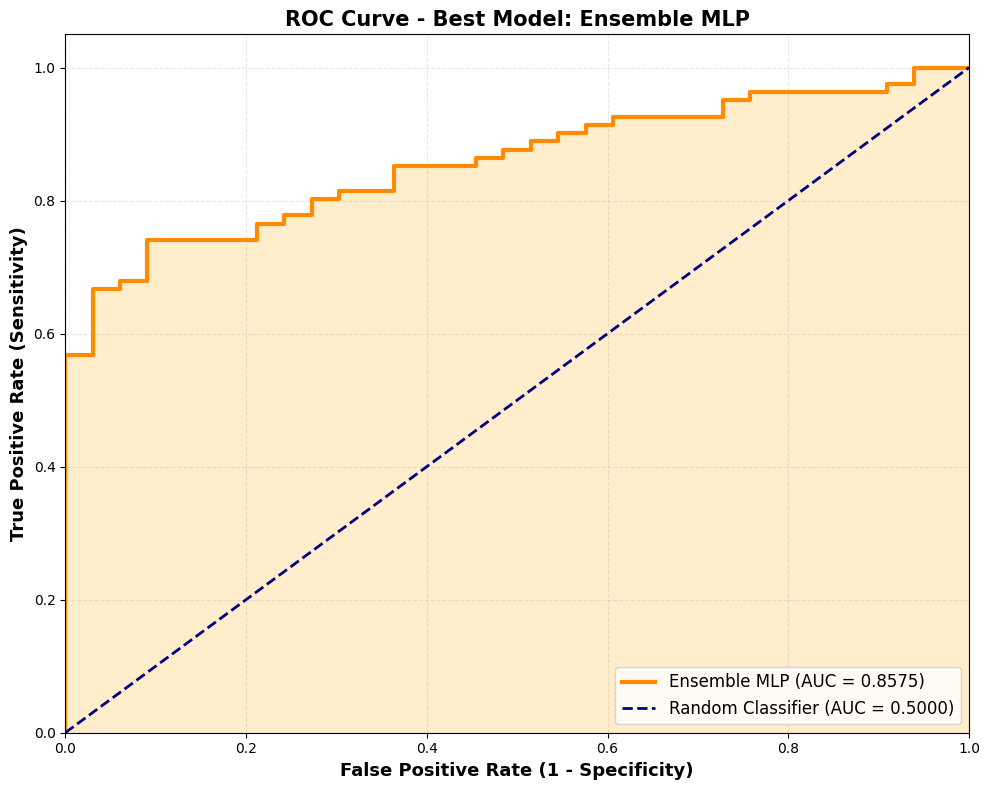

BEST MODEL: Ensemble MLP
ROC-AUC Score: 0.8575

✓ Plot saved: best_model_roc_curve.png


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Cell: Plot ROC untuk Best Model Only (lebih clean)
best_model_name = results.iloc[0]['Model']

if best_model_name == 'Single MLP':
    y_proba_best = y_proba_single
    model_label = 'Single MLP'
elif best_model_name == 'Ensemble MLP':
    y_proba_best = y_proba_ensemble
    model_label = 'Ensemble MLP'
else:
    y_proba_best = y_proba_bagging
    model_label = 'Bagging MLP'

fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, 
         label=f'{model_label} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5000)')

plt.fill_between(fpr, tpr, alpha=0.2, color='orange')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=13, fontweight='bold')
plt.title(f'ROC Curve - Best Model: {model_label}', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('best_model_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*70)
print(f"BEST MODEL: {model_label}")
print("="*70)
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"\n✓ Plot saved: best_model_roc_curve.png")


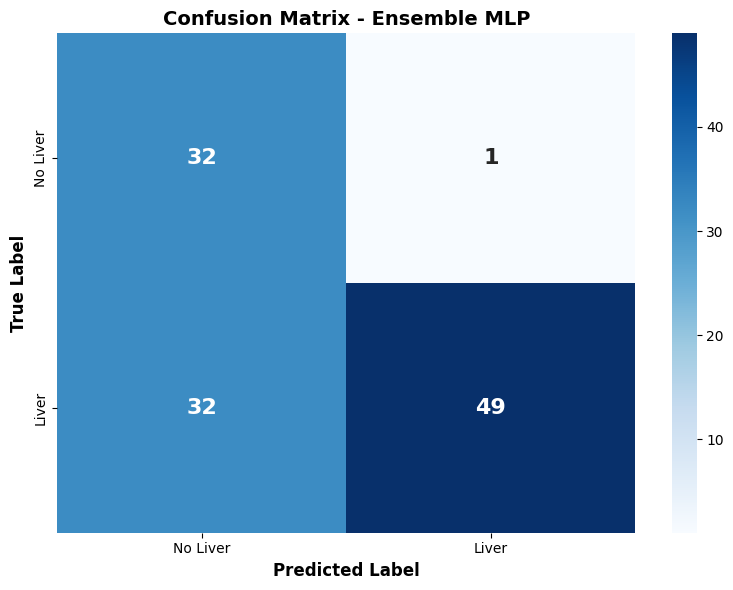

TN: 32, FP: 1
FN: 32, TP: 49

✓ Plot saved: confusion_matrix.png


In [18]:
# Cell: Plot Confusion Matrix dengan Heatmap
import seaborn as sns

if best_model_name == 'Single MLP':
    y_pred_best = y_pred_test
elif best_model_name == 'Ensemble MLP':
    y_pred_best = y_pred_ensemble
else:
    y_pred_best = y_pred_bagging

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Liver', 'Liver'],
            yticklabels=['No Liver', 'Liver'],
            annot_kws={"size": 16, "weight": "bold"})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - {model_label}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")
print(f"\n✓ Plot saved: confusion_matrix.png")


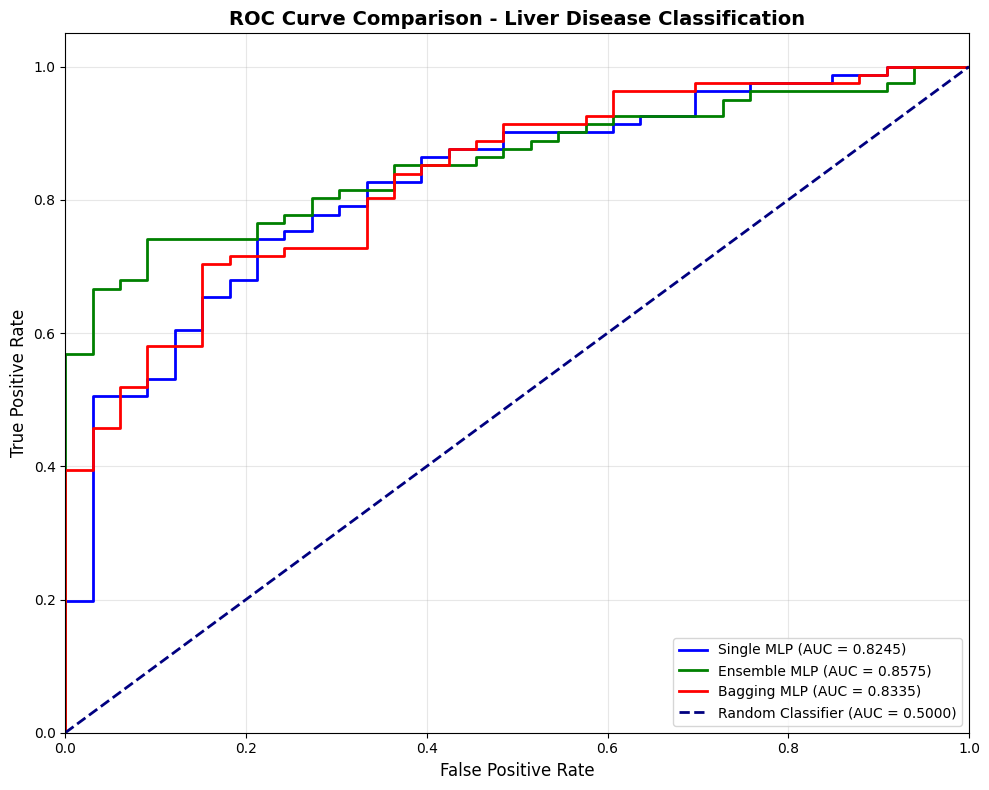

ROC-AUC SCORES
Single MLP:    0.8245
Ensemble MLP:  0.8575
Bagging MLP:   0.8335

✓ Plot saved: roc_auc_comparison.png


In [19]:
# Cell: Plot ROC-AUC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_proba_single = best_mlp.predict_proba(X_test_scaled)[:, 1]
y_proba_ensemble = ensemble.predict_proba(X_test_scaled)[:, 1]
y_proba_bagging = bagging.predict_proba(X_test_scaled)[:, 1]

fpr_single, tpr_single, _ = roc_curve(y_test, y_proba_single)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_proba_ensemble)
fpr_bagging, tpr_bagging, _ = roc_curve(y_test, y_proba_bagging)

roc_auc_single = auc(fpr_single, tpr_single)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
roc_auc_bagging = auc(fpr_bagging, tpr_bagging)

plt.figure(figsize=(10, 8))
plt.plot(fpr_single, tpr_single, color='blue', lw=2, 
         label=f'Single MLP (AUC = {roc_auc_single:.4f})')
plt.plot(fpr_ensemble, tpr_ensemble, color='green', lw=2, 
         label=f'Ensemble MLP (AUC = {roc_auc_ensemble:.4f})')
plt.plot(fpr_bagging, tpr_bagging, color='red', lw=2, 
         label=f'Bagging MLP (AUC = {roc_auc_bagging:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Liver Disease Classification', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_auc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*70)
print("ROC-AUC SCORES")
print("="*70)
print(f"Single MLP:    {roc_auc_single:.4f}")
print(f"Ensemble MLP:  {roc_auc_ensemble:.4f}")
print(f"Bagging MLP:   {roc_auc_bagging:.4f}")
print(f"\n✓ Plot saved: roc_auc_comparison.png")


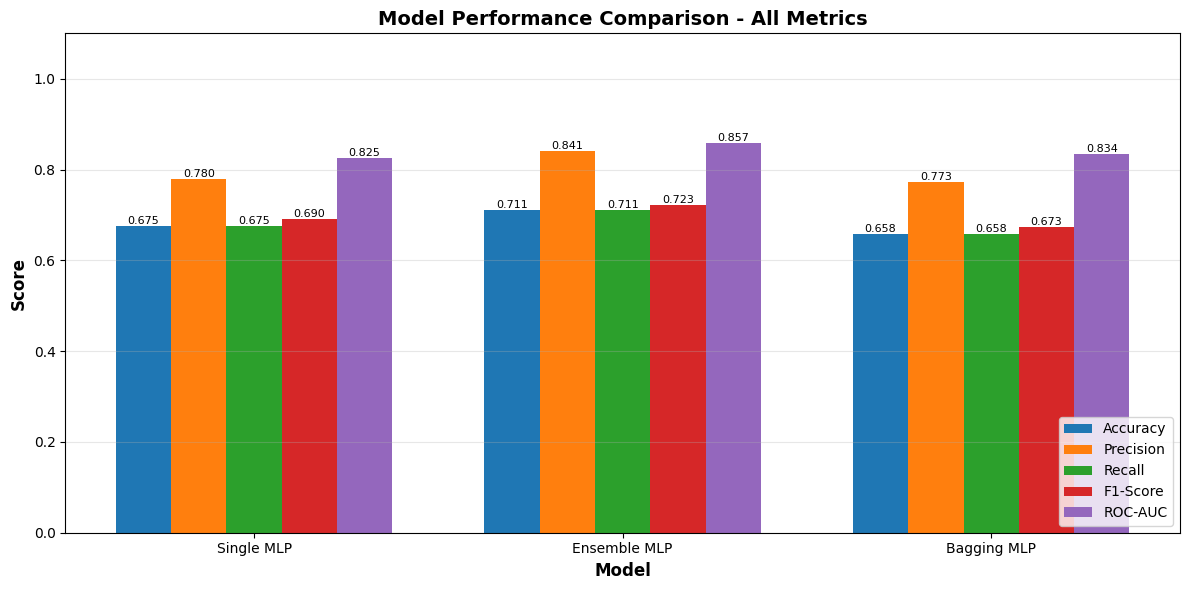


Metrics Summary:
       Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
  Single MLP  0.675439   0.779825 0.675439  0.690096 0.824542
Ensemble MLP  0.710526   0.841053 0.710526  0.722532 0.857464
 Bagging MLP  0.657895   0.772937 0.657895  0.672814 0.833520

✓ Plot saved: metrics_comparison.png


In [20]:
# Cell: Plot All Metrics Comparison
metrics_data = {
    'Model': ['Single MLP', 'Ensemble MLP', 'Bagging MLP'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_test),
        accuracy_score(y_test, y_pred_ensemble),
        accuracy_score(y_test, y_pred_bagging)
    ],
    'Precision': [
        precision_score(y_test, y_pred_test, average='weighted'),
        precision_score(y_test, y_pred_ensemble, average='weighted'),
        precision_score(y_test, y_pred_bagging, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_test, average='weighted'),
        recall_score(y_test, y_pred_ensemble, average='weighted'),
        recall_score(y_test, y_pred_bagging, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_test, average='weighted'),
        f1_score(y_test, y_pred_ensemble, average='weighted'),
        f1_score(y_test, y_pred_bagging, average='weighted')
    ],
    'ROC-AUC': [roc_auc_single, roc_auc_ensemble, roc_auc_bagging]
}

metrics_df = pd.DataFrame(metrics_data)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(metrics_df['Model']))
width = 0.15

bars1 = ax.bar(x - 2*width, metrics_df['Accuracy'], width, label='Accuracy', color='#1f77b4')
bars2 = ax.bar(x - width, metrics_df['Precision'], width, label='Precision', color='#ff7f0e')
bars3 = ax.bar(x, metrics_df['Recall'], width, label='Recall', color='#2ca02c')
bars4 = ax.bar(x + width, metrics_df['F1-Score'], width, label='F1-Score', color='#d62728')
bars5 = ax.bar(x + 2*width, metrics_df['ROC-AUC'], width, label='ROC-AUC', color='#9467bd')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison - All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'])
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

for bars in [bars1, bars2, bars3, bars4, bars5]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))
print(f"\n✓ Plot saved: metrics_comparison.png")


In [21]:
# # Cell: Keras MLP dengan Dropout + Batch Normalization
# from tensorflow import keras
# from tensorflow.keras import layers

# model = keras.Sequential([
#     layers.Dense(128, input_shape=(X_train_resampled.shape[1],)),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.4),
    
#     layers.Dense(64),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.3),
    
#     layers.Dense(32),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.2),
    
#     layers.Dense(1, activation='sigmoid')
# ])

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# early_stop = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=20,
#     restore_best_weights=True
# )

# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=10,
#     min_lr=0.00001
# )

# history = model.fit(
#     X_train_resampled, y_train_resampled,
#     epochs=200,
#     batch_size=32,
#     validation_split=0.2,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )

# y_pred_keras = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()

# print(f"\nKeras Accuracy: {accuracy_score(y_test, y_pred_keras):.4f}")
# print(f"\nConfusion Matrix:")
# print(confusion_matrix(y_test, y_pred_keras))
# print(f"\nClassification Report:")
# print(classification_report(y_test, y_pred_keras, target_names=['No Liver', 'Liver']))
